## Bayes on Grids

Concepts taught here:

* Probabilistic generative models (PGM)
* How posterior distributions and evidence answer interesting science questions
* How these can be computed numerically
* Prior predictive checks
* Bayesian model comparison



In [125]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import log10, exp, log, pi

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['figure.dpi'] = 100

# if you cannot see plots, you may need to include: %matplotlib inline

# Introduction

Lets say you are given a data set of two observables, period and luminosity, and are told: **"Fit a line to these data"**.

To have a concrete example, lets generate some data:


## Generative process (unknown to observers)

We assume there is a physical, perhaps stochastic process which generates observations. This includes making the objects of interest in the Universe, our observing equipment. 

For simulating, we choose this process with all its details. (Later, as observers, we will not know it and will try to infer it.)

A **probabilistic generative model (PGM)** is also a story. Here is the story of this simulated Universe:

![PGM](img/PGM.png)

First, cepheids are created from Gaussian distributions of periods and metallicities. 

For those interested: short videos on [Cepheids](https://www.youtube.com/watch?v=7ohkKiZTJOg), a type of pulsating, massive, yellow stars and [metallicities](https://www.youtube.com/watch?v=CLrVwVeTN78), a measure of heavier-than-helium element content.

Each cepheid follows the luminosity-period-metallicity law, which deterministically determines its luminosity as follows:




$\log L=0.2 \times (\alpha + \beta \times (\log(P / {10 \mathrm{days}}) + \gamma \times Z))$

with $\alpha=-4.4$, $\beta=-2.8$ $\gamma=-0.3$. In code:

In [126]:
def luminosity_model(period, metallicity, alpha, beta, gamma, P0=10.0):
    return 10**(-0.2 * (alpha + beta * (log10(period/P0) + gamma * metallicity)))

true_alpha = -4.4
true_beta  = -2.8
true_gamma = -0.3


Here is a plot of our law:

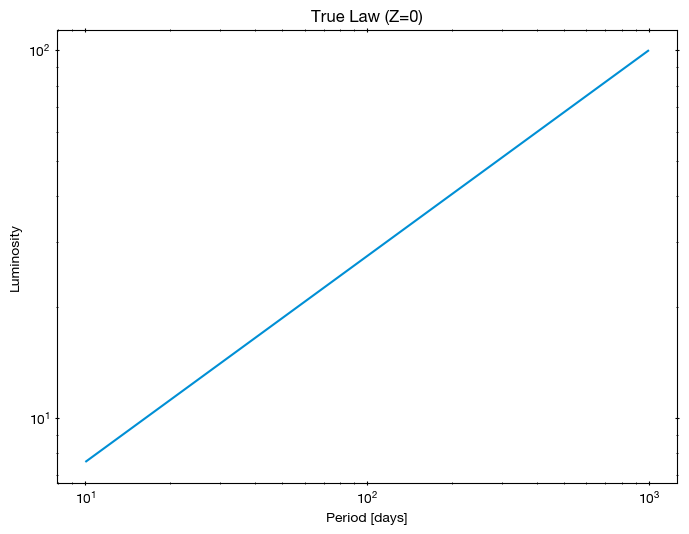

In [127]:
grid_P = np.linspace(10, 1000, 4000)
plt.plot(grid_P, luminosity_model(grid_P, 0, true_alpha, true_beta, true_gamma))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Period [days]")
plt.ylabel("Luminosity")
plt.title("True Law (Z=0)");

Lets now create our cepheids. Here are their true properties:

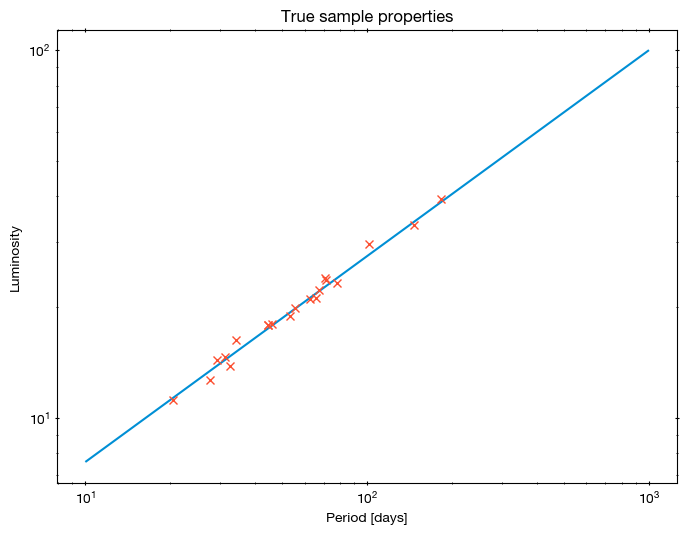

In [128]:
# set the random number generator seed so that we get a consistent data sample:
np.random.seed(42)

N_obs = 20

true_metallicity = np.random.normal(0, 0.1, size=N_obs)
true_period = 10**np.random.normal(1.8, 0.25, size=N_obs)
true_luminosity = luminosity_model(true_period, true_metallicity, true_alpha, true_beta, true_gamma)

plt.plot(grid_P, luminosity_model(grid_P, 0, true_alpha, true_beta, true_gamma))
plt.plot(true_period, true_luminosity, 'x ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Period [days]")
plt.ylabel("Luminosity")
plt.title("True sample properties");

Notice there is some scatter, because of the metallicity effect.

**Important**: All of the above are properties we do not know. 

The final step in the generating process is to take observations:

# Generate some observed data



Lets simulate what the observer can get their hands on, which are noisy measurements:

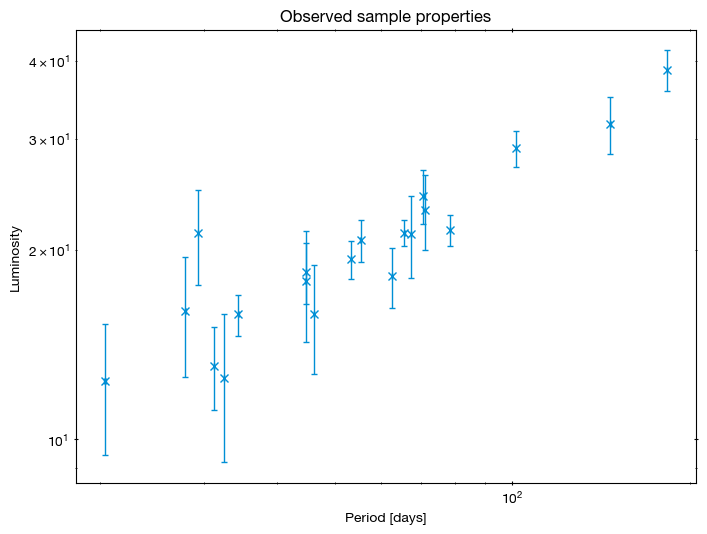

In [129]:
experimental_noise_period = np.random.uniform(0, 0.1, size=N_obs)
experimental_noise_luminosity = np.random.uniform(1, 4, size=N_obs)

obs_period = np.random.normal(true_period, experimental_noise_period)
obs_luminosity = np.random.normal(true_luminosity, experimental_noise_luminosity)

plt.errorbar(x=obs_period, xerr=experimental_noise_period, 
             y=obs_luminosity, yerr=experimental_noise_luminosity, 
             marker='x', ls=' ', capsize=2, elinewidth=1)
plt.xlabel("Period [days]")
plt.ylabel("Luminosity")
plt.yscale('log')
plt.xscale('log')
plt.title("Observed sample properties");

Here is the full generative process as a graphical model:

![PGM](img/PGM-full.png)


# Inference Problem

## Motivation

If we knew the period-luminosity relationship, we could infer the intrinsic luminosity by just measuring the period. --> This **predictiveness** is useful for cosmology

The period-luminosity relationship can also tell us something about the interior of stars --> Comparing the data to models gives insights about **physical processes** in the Universe.

## Inference

We lack information, which introduces uncertainty. 

1. One source of uncertainty is that we do not know the true process. For example, we may not be aware that metallicity (which we did not measure) is part of the generative model. This is **systematic uncertainty** (aka epistemic uncertainty).
2. Another source of uncertainty is our limited data: The instrument does not allow us to measure periods and luminosities perfectly and we only have a finite data set. This is **statistical uncertainty** (alearic uncertainty).

We address (2) by quantifying the uncertainty assuming a probabilistic generative model (**parameter estimation**). We address (1) by either criticising them in isolation (**model criticism**), for example with visualisation or exploring several models and comparing them (**model comparison**).

## Assumptions

So we want to learn the period-luminosity relationship. We assume it has the shape:

$\log L=0.2 \times (\alpha + \beta \times (\log(P / {10 \mathrm{days}}))$

As you see, our model is a simplification and approximation of the true process.

From our sample, we have uncertain Gaussian measurements of L and uncertain measurements of P. 

## Goals

We want to know the two parameters:

 * $\alpha$: related to the luminosity for 10 days-periodic cepheids and 
 * $\beta$: related to how strongly the luminosity and period are related.

But what does that really mean to "know" or "constrain" parameters?


# Why Bayesian inference

* There is a true value out there in the Universe, but we will never be able to measure it perfectly with infinite precision.
* We can instead talk about it being within some interval, or not.
* With probability theory, we can talk about the probability of the parameter to be within a interval.
  * We use parameter probability distributions to describe our current state of information.
  * These do not imply the value really has a distribution. (It also does not mean that if you created many Universes, they would follow that distribution)

So if we have some data $D$, we would like a method to produce a probability distribution for us, $P(\alpha)$.

Since the probability is conditional on what data we feed it, we can write $P(\alpha|D)$, which is read as "The probability of $\alpha$ given D".

The probability distribution is normalised ($\int_{-\infty}^\infty P(\alpha|D) d\alpha=1$).

Unfortunately, there is no method which can produce $P(\alpha|D)$ just from D. 
However, if we knew $\alpha$, we can produce data sets! This generating is what we did above.

So we can talk about how frequently some dataset D is produced given $\alpha$: $P(D|\alpha)$. This probability distribution is normalised, but over all possible data outcomes: ($\int_{-\infty}^\infty P(D|\alpha) dD=1$).

## Enter Bayes theorem

![Conditional probability](img/conditional-probability.png)

A simple Venn diagram (above) can tell you that

$P(A \cap B) P(A) = P(B \cap A) P(B)$

The law of conditional probabilities is analogous:

$P(A | B) P(A) = P(B | A) P(B)$

If we translate this to our problem, and move one term over, we get Bayes' theorem:

$P(\alpha|D) = \frac{P(D|\alpha) \times P(\alpha)}{P(D)}$

where the terms are:

* $P(\alpha|D)$: Posterior probability distribution
  * This is the information we want: A probability over $\alpha$ given the data.

* $P(D|\alpha)$: Sampling distribution
  * This is information we have: It encodes how data are probabilistically generated, assuming our model and given the model parameter $\alpha$.
  * It is a function of $\alpha$, not a probability density over $\alpha$. It helps us update a auxiliary probability density over $\alpha$, namely:

* $P(\alpha)$: Prior probability distribution (of $\alpha$)
  * This probability distribution is a starting point we have to use.
  * It is our state of information before we take the data.
  * For example:
    * A maximally ignorant state (very wide flat distribution) (Jeffrey's priors maximize the entropy)
    * A informed state from previous experiments
    * A informed state from prior theoretical knowledge (part of the model)

* The Bayesian evidence or marginal likelihood  

  * We can also compute this because we know that the posterior needs to be normalised: $P(D)=\int_{-\infty}^\infty P(\alpha|D) d\alpha=\int_{-\infty}^\infty P(D|\alpha) \times P(\alpha) d\alpha$.
 

## Bayes theorem in practice (with grids)

### Prior

Lets use uninformative priors. "Let the data speak for themselves" they say. Lets see what that means.

Lets try a uniform prior probability on $\alpha$ between -10 and 0:

  $P(\alpha) = 1 / 10$ for $\alpha\in[-10,0]$ and zero elsewhere.

Another way to write it is like this:

  $\alpha$ ~ Uniform(-10, 0)

Read "~" as "is distributed as a".

Lets generate a grid to represent this:

In [130]:
N_grid = 401

alphas_grid = np.linspace(-10, 0, N_grid)
alphas_middle = (alphas_grid[1:] + alphas_grid[:-1]) / 2
alphas_step = (alphas_grid[1:] - alphas_grid[:-1])

alphas_middle[::10]


array([-9.9875, -9.7375, -9.4875, -9.2375, -8.9875, -8.7375, -8.4875,
       -8.2375, -7.9875, -7.7375, -7.4875, -7.2375, -6.9875, -6.7375,
       -6.4875, -6.2375, -5.9875, -5.7375, -5.4875, -5.2375, -4.9875,
       -4.7375, -4.4875, -4.2375, -3.9875, -3.7375, -3.4875, -3.2375,
       -2.9875, -2.7375, -2.4875, -2.2375, -1.9875, -1.7375, -1.4875,
       -1.2375, -0.9875, -0.7375, -0.4875, -0.2375])

Each value is assumed equally probable by our prior.

In [131]:
prior_density = 1 / (alphas_grid[-1] - alphas_grid[0])
prior = prior_density * alphas_step

But what if we used a flat prior (uniform spacing) on $\log-\alpha$ instead?

It would be uninformative (flat) in that variable, but the prior on $\alpha$ would not be flat.

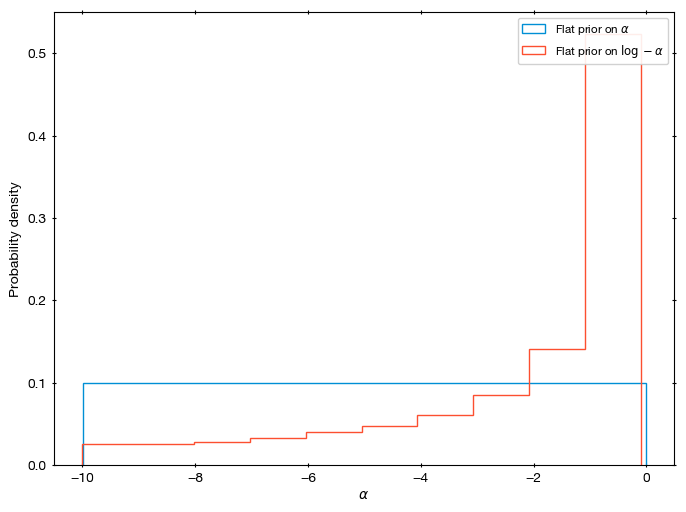

In [132]:
plt.hist(alphas_middle, histtype='step', label="Flat prior on $\\alpha$", density=True)
plt.hist(-10**np.linspace(-1, 1, N_grid), histtype='step', label="Flat prior on $\log-\\alpha$", density=True)
plt.xlabel("$\\alpha$")
plt.ylabel("Probability density")
plt.legend(loc='best');

As you can see, there is no objectively uniform prior -- it depends on the parameterization!

Conversely, any prior is flat in some reparameterization.

### Likelihood function

Given a $\alpha$ value and some data D, we need a function that computes the probability for those data to arise from it.

So we need to specify a model:

![model](img/PGM-modelled.png)

We have a deterministic part of the model:

 $\log L(P|\alpha,\beta)=0.2 \times \left(\alpha + \beta \times (\log(P / {10 \mathrm{days}})\right)$

For now we assume $\beta = -3$ to keep the problem 1d.

This allows us to predict L given a P. But we only have a measured P and a measured L. For now we ignore the small P uncertainties, but write for the observed L:

 $ L_i$ ~ Normal($L(P_i|\alpha,\beta)$, $\sigma_i$)

We know $L_i$ from our measurements and $\sigma_i$ from calibration data of our instrument (a sort of model as well).

For one data point $d_i=(P_i, L_i,\sigma_i)$ given $\alpha$ and $\beta$, our Gaussian likelihood is therefore

 $P(d_i|\alpha) = \mathrm{GaussianPDF}(L_i | L(P_i|\alpha,\beta), \sigma_i)$

or spelling it out:

 $P(d_i|\alpha) = (2 \pi \sigma_i^2)^{-\frac{1}{2}} \exp\left(-\left(\frac{L_i - L(P_i|\alpha,\beta)}{2\sigma_i}\right)^2\right)$

Since we want to analyse all data points and require this model to hold for all (logical AND), we multiply the probabilities and obtain our likelihood function:

 $P(D|\alpha) = \prod_i P(d_i|\alpha)$

If we drop some constant factors and work in logarithms, we can write:

 $-2 \log P(D|\alpha) = \sum_i \left(\frac{L_i - L(P_i|\alpha,\beta)}{2\sigma_i}\right)^2 $ 

Which is sometimes referred to as $\chi^2$ -- it is just the -2 times the log-likelihood of a Gaussian observation model.

Lets implement this:


In [133]:
def loglikelihood(alpha, beta=-3):
    expected_luminosities = luminosity_model(obs_period, alpha=alpha, beta=beta, metallicity=0, gamma=0)
    chi2 = (((obs_luminosity - expected_luminosities) / experimental_noise_luminosity)**2).sum()
    return -chi2 / 2


In [134]:
def generate_luminosity_data(alpha, beta=-3):
    experimental_noise_period = np.random.uniform(0, 0.1, size=N_obs)  # not used
    experimental_noise_luminosity = np.random.uniform(1, 3, size=N_obs)

    true_luminosity = luminosity_model(obs_period, alpha=alpha, beta=beta, metallicity=0, gamma=0)
    obs_luminosity = np.random.normal(true_luminosity, experimental_noise_luminosity)
    return obs_luminosity


## Prior predictive checks

Lets have a look what data each prior grid point would generate:

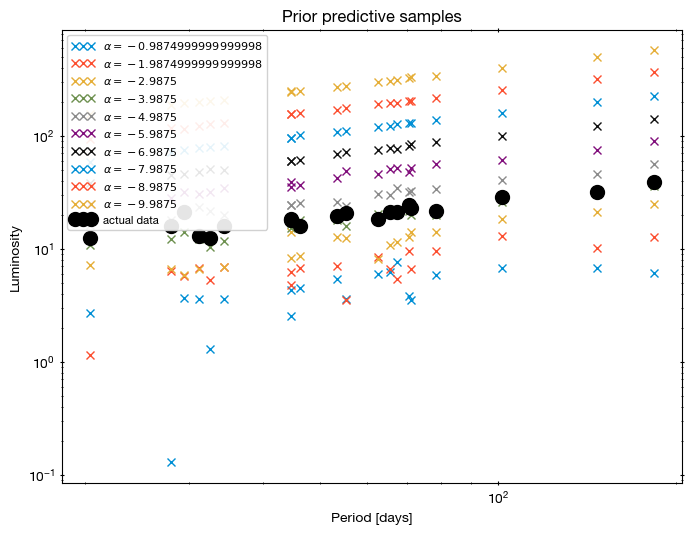

In [135]:
for alpha in alphas_middle[::40][::-1]:
  plt.plot(obs_period, generate_luminosity_data(alpha), 'x ', label='$\\alpha=%s$' % alpha)

plt.plot(obs_period, obs_luminosity, 'o ', color='k', ms=10, label='actual data')

plt.legend(loc='upper left', prop=dict(size=8))

plt.xlabel("Period [days]")
plt.ylabel("Luminosity")
plt.yscale('log')
plt.xscale('log')
plt.title("Prior predictive samples");

Lets plot our loglikelihood function:

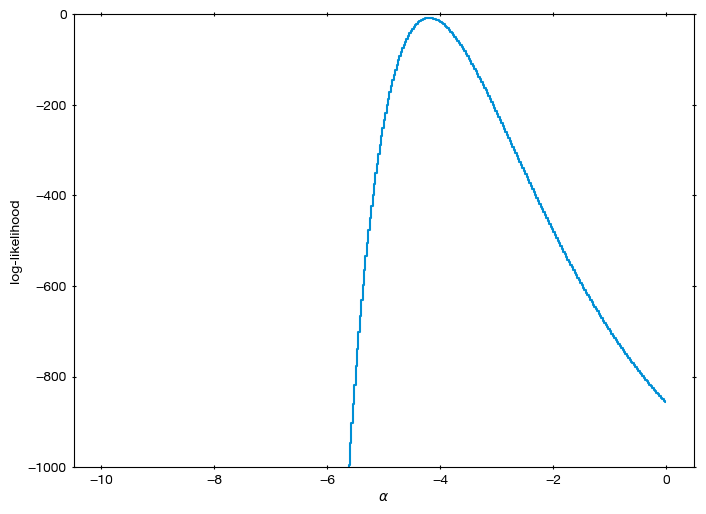

In [136]:
loglikelihoods = np.array([loglikelihood(alpha) for alpha in alphas_middle])
plt.plot(alphas_middle, loglikelihoods, drawstyle='steps-mid')
plt.ylim(-1000, 0);
plt.ylabel("log-likelihood")
plt.xlabel("$\\alpha$");

The model most frequently making data that looks closest to our observed sample  near $\alpha=-4$.

So lets compute the probability distribution:

First we compute the normalising constant (**evidence**):

In [154]:
# to avoid overflows and underflows, we subtract a constant
posterior_unnormalised = np.exp(loglikelihoods - loglikelihoods.max()) * alphas_step

# the same as above, but in log, which is more stable
logposterior_unnormalised = loglikelihoods + log(alphas_step)

# compute log-evidence, add back the constant
logevidence = np.log(posterior_unnormalised.sum()) + loglikelihoods.max()

logevidence, posterior_unnormalised.sum(), loglikelihoods.max()

(-10.395592057686736, 0.11442464665918742, -8.227753277270889)

Verify that it is now a **normalised** posterior probability distribution:

In [156]:
posterior = np.exp(logposterior_unnormalised - logevidence)

posterior.sum()

1.0000000000000004

Plot the **posterior probability distribution**:

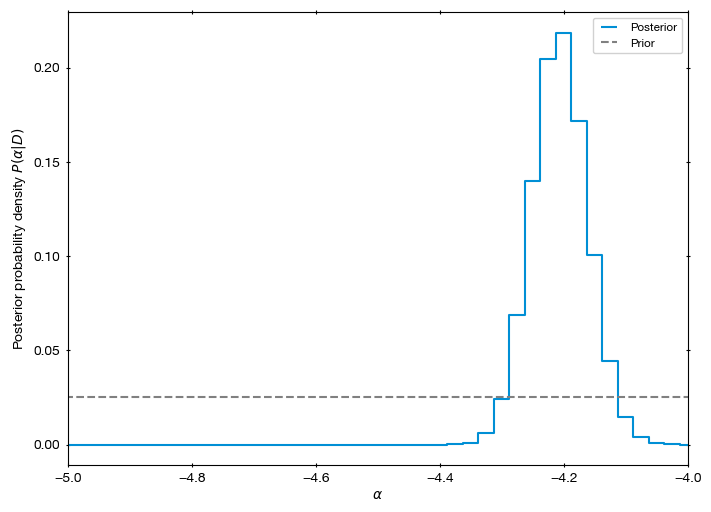

In [139]:
plt.plot(alphas_middle, posterior, drawstyle='steps', label='Posterior')
plt.plot(alphas_middle, alphas_step, drawstyle='steps', ls='--', color='gray', label='Prior')
plt.ylabel("Posterior probability density $P(\\alpha|D)$")
plt.xlabel("$\\alpha$")
plt.legend(loc='best')
plt.xlim(-5, -4);

The **information gain** (https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) can be quantified (in bits) as:

$\int P(\alpha|D)\log_2\frac{P(\alpha|D)}{P(\alpha)}d\alpha$:

In [140]:
with np.errstate(divide='ignore', invalid='ignore'):
    information_gain_bits = (posterior * np.log2(posterior / prior))[posterior>0].sum()
    print('Information gain: %.1f bits' % information_gain_bits)


Information gain: 5.7 bits


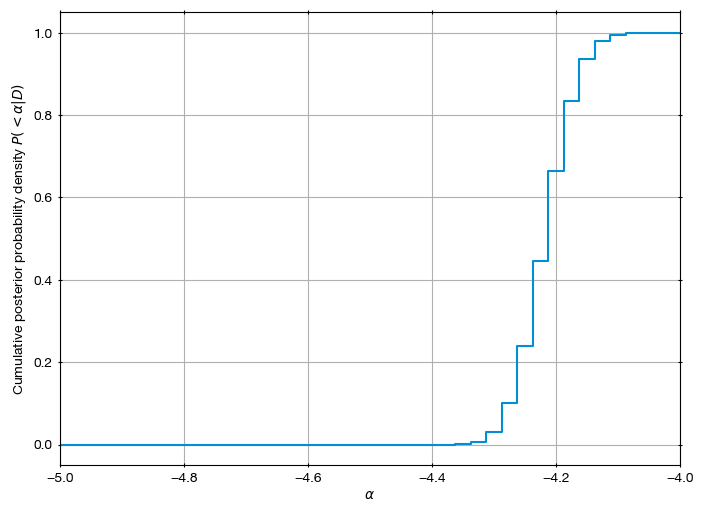

In [141]:
plt.plot(alphas_middle[posterior>0], posterior[posterior>0].cumsum(), drawstyle='steps')
plt.ylabel("Cumulative posterior probability density $P(<\\alpha|D)$")
plt.xlabel("$\\alpha$")
plt.grid()
plt.xlim(-5, -4);


Lets see what the probable models look like:

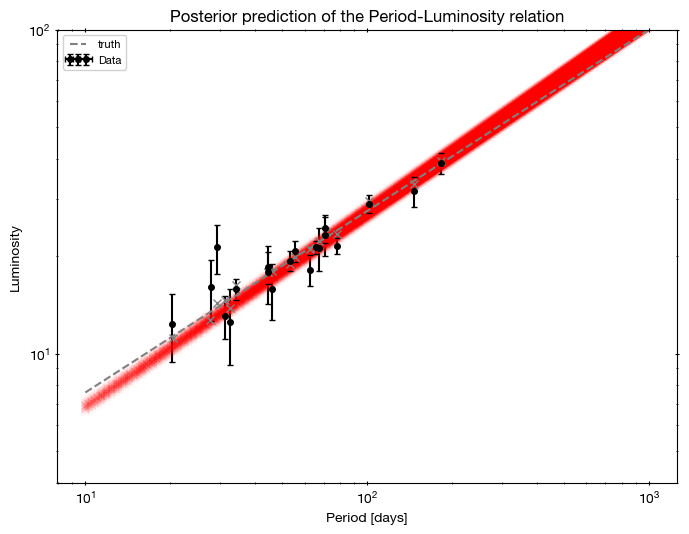

In [146]:
for alpha, alpha_posterior in zip(alphas_middle, posterior):
  plt.plot(
      # predict relation with this alpha
      grid_P, luminosity_model(grid_P, alpha=alpha, beta=-3, metallicity=0, gamma=0), 
      'x ', color='r', alpha=alpha_posterior # weigh by their probability
  )

plt.errorbar(x=obs_period, y=obs_luminosity, xerr=experimental_noise_period, yerr=experimental_noise_luminosity, 
             ls=' ', marker='o', color='k', ms=4, label='Data')

plt.plot(grid_P, luminosity_model(grid_P, 0, true_alpha, true_beta, true_gamma), '--', color='gray', label='truth')
plt.plot(true_period, true_luminosity, 'x ', color='gray')

plt.legend(loc='upper left', prop=dict(size=8))

plt.xlabel("Period [days]")
plt.ylabel("Luminosity")
plt.yscale('log')
plt.xscale('log')
plt.ylim(4, 100)
plt.title("Posterior prediction of the Period-Luminosity relation");

* Note that the posterior models are much narrower than the prior predictions. We learned a lot!

* The model is near the data, but there may be some scatter additional to what is expected from the error bars.



# Questions to discuss

(5 points for contributing something to the discussion!)

* What is the most probable value for $\alpha$?

* In which interval is 90% of the posterior probability is contained? Is this credible interval uniquely defined?

* What is the probability that $\alpha<-4.4$?

* How did the prior (uniform grid) influence the posterior here?
  What would happen if we had parameterized our model with parameter $\alpha' = \log(-\alpha)$ instead and used a flat uniform prior on $\alpha'$ instead?

  * How would the posterior probability density change? In which region is more probability mass placed?

* Lets say we manually adjust our prior to be very close to the posterior, for example $\alpha$~Uniform(-4.5,-4.2).

  * Would the prior predictive checks be more diverse or less diverse?

  * Would the typical likelihood values become higher or lower?

  * How would the posterior probability density normalisation -- the evidence (marginalised/averaged likelihood) -- change? Would it increase or decrease? 

  * Do the likelihood function values change if we change the prior?


# Take-aways

* Priors are always there when inferring probability distributions. Sometimes they are implicit via the chosen parameterization of the space.

* Probabilistic generative models tell a complete story of the physical process of interest and the measurement process.

* Posterior probabilities represent our state of information after data were taken.

* The Bayesian evidence punishes prediction diversity. Bayes factors and posterior odds ratios are one kind of model comparison.

* For problems with several parameters, we need to go beyond grids.

--> Next: How to compute posterior probability distributions and the evidence with Monte Carlo methods.

# The curse of dimensionality

In our model, we made quite a few assumptions, fixing parameters:

* we assumed $\beta=-3$
* we assumed $\sigma_P=0$
* we assumed $\gamma=0$ and no systematic scatter about our law.

* If we extend our model to explore other parameters (such as $\beta$), how does the number of grid points (and thus the number of likelihood evaluations we need to perform) scale with parameters?

## 2d grid

Lets make a grid in two dimensions (over $\alpha$ and $\beta$):

In [147]:
betas_grid = np.linspace(-5, 2, N_grid // 10)
betas_middle = (betas_grid[1:] + betas_grid[:-1]) / 2
betas_step = betas_grid[1:] - betas_grid[:-1]

grid = np.meshgrid(alphas_middle, betas_middle)
grid_cellsize = np.product(np.meshgrid(alphas_step, betas_step), axis=0)

print(grid[0].shape, grid[1].shape, grid_cellsize.shape)

(39, 400) (39, 400) (39, 400)


Evaluate the likelihood and get the 2d normalised posterior probability distribution:

In [148]:

grid_unnormalised_logposterior = np.vectorize(loglikelihood)(grid[0], grid[1]) + np.log(grid_cellsize)
grid_unnormalised_posterior = np.exp(grid_unnormalised_logposterior)
grid_logevidence = np.log(grid_unnormalised_posterior.sum())
grid_posterior = np.exp(grid_unnormalised_logposterior - grid_logevidence)

grid_posterior.sum()

0.9999999999999999

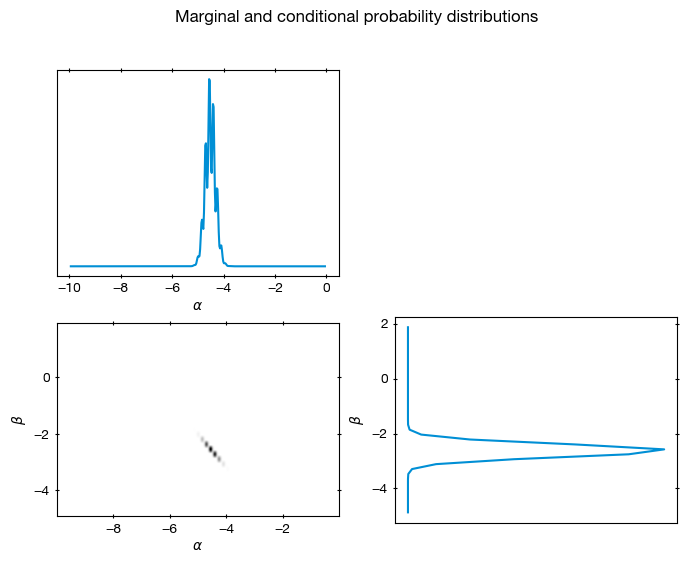

In [149]:
plt.subplot(2, 2, 3)
plt.imshow(
      grid_posterior[::-1],
      extent=(alphas_middle[0], alphas_middle[-1], betas_middle[0], betas_middle[-1]),
      aspect='equal', cmap='gray_r')
#plt.colorbar(label='log-likelihood')
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$");
plt.subplot(2, 2, 1)
plt.plot(alphas_middle, grid_posterior.sum(axis=0))
plt.xlabel("$\\alpha$")
plt.yticks([])
plt.subplot(2, 2, 4)
plt.plot(grid_posterior.sum(axis=1), betas_middle)
plt.ylabel("$\\beta$")
plt.xticks([])
plt.suptitle("Marginal and conditional probability distributions");


## Bayesian model comparison

We marginalised the likelihoods to model evidences: $Z_1=P(D|M_1)$, $Z_2=P(D|M_2)$.

In [150]:
print("log10(Z) of 1d model (beta fixed ): %.2f" % (logevidence))
print("log10(Z) of 2d model (beta varies): %.2f" % (grid_logevidence))

log10(Z) of 1d model (beta fixed ): -10.40
log10(Z) of 2d model (beta varies): -9.61



These can be used to compute relative probabilities of **models**, by applying Bayes' theorem once again:

$P(M_1|D) = \frac{P(D|M_1) * P(M_1)}{\sum_i P(D|M_i) * P(M_i)}$

For this step, we first need to define prior model probabilities $P(M_i)$ for each model.

If we assume a 1:100 odds ratio, this is:

In [151]:
prior_odds = 0.01
model_prior_1d = prior_odds / (1 + prior_odds)
model_prior_2d = 1 / (1 + prior_odds)

print("Prior probability P(1dmodel) = %2f" % (prior_odds / (1 + prior_odds)))
print("Prior probability P(2dmodel) = %2f" % (1 / (1 + prior_odds)))

Prior probability P(1dmodel) = 0.009901
Prior probability P(2dmodel) = 0.990099


Posterior model probabilities $P(M_i|D)$ give the relative probability of one model being the right one:

In [152]:
print("Posterior model probability P(1dmodel|D) = %2f" % (np.exp(logevidence) * prior_odds / (np.exp(logevidence) * prior_odds + np.exp(grid_logevidence))))
print("Posterior model probability P(2dmodel|D) = %2f" % (np.exp(grid_logevidence) / (np.exp(logevidence) * prior_odds + np.exp(grid_logevidence))))

Posterior model probability P(1dmodel|D) = 0.004557
Posterior model probability P(2dmodel|D) = 0.995443


A quantification of how much the odds have shifted is the **Bayes factor**:

In [153]:
bayes_factor = np.exp(logevidence - grid_logevidence)

print("Bayes factor: P(D|1dmodel)/P(D|2dmodel) = %.2f" % bayes_factor)

Bayes factor: P(D|1dmodel)/P(D|2dmodel) = 0.46


If the Bayes factor is close to 1, there is "not much evidence" in favor of one or the other model.

Recall that model evidences (marginal likelihoods) are likelihoods averaged over the entire parameter space.

Benefits:

1. Bayes factors capture the entire model parameter space, not just the "best fit". 
2. Bayes factors punish model diversity ("built-in Occam's razor")

Limitations:

3. Dependence on priors: Because of (1), the results strongly depend on the parameter priors. They also strongly depend on the chosen prior model probabilities, which need to be chosen.

   * This means posterior odds can be meaningful and appropriate for competing physical models where these priors can be specified. 
   * For ad-hoc/empirical models, they are almost never useful --> see model comparison lecture later.

4. Bayesian inference assumes that the true hypothesis is within the specified model and parameter set ("Closed world assumption", "M-closed"). This applies to parameter estimation and model comparison.

5. Bayesian inference does not make decisions. It only weighs probabilities.  Posterior odds do not state the probability of making a false decision. For this, a frequentist characterisation of imposing a threshold is needed, based on simulations!


# Ticket to leave

Fill out the [form below](https://indico.ph.tum.de/event/6875/surveys/5) and then you can leave the class. (+5 points)

In [26]:
%%html

<iframe src="https://indico.ph.tum.de/event/6875/surveys/5" style="width: 100%; height: 400px"></iframe>